# Predicting the effect of combinatorial drug treatments

In this tutorial, we predict the effect of combinatorial drug treatments on the A549 cell line. We will also look at the effect of the encoder-decoder module. 

## Preliminaries

In [1]:
import warnings
from pandas.errors import SettingWithCopyWarning
import matplotlib

%matplotlib inline

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", SettingWithCopyWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import jax
from tqdm import tqdm
import functools
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import rapids_singlecell as rsc
import flax.linen as nn
import optax
import pertpy
import cellflow
from cellflow.model import CellFlow
import cellflow.preprocessing as cfpp
from cellflow.utils import match_linear
from cellflow.plotting import plot_condition_embedding
from cellflow.preprocessing import transfer_labels, compute_wknn, centered_pca, project_pca, reconstruct_pca, annotate_compounds, get_molecular_fingerprints
from cellflow.metrics import compute_r_squared, compute_e_distance


/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


We download the data from [pertpy](https://pertpy.readthedocs.io/en/stable/):

In [2]:
adata = pertpy.data.combosciplex()
adata.obs.head()

,sample,Size_Factor,n.umi,RT_well,Drug1,Drug2,Well,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,condition,pathway1,pathway2,split,control,cell_type
Cell,,,,,,,,,,,,,,,,,,,
A01_A02_RT_BC_10_Lig_BC_18,sciPlex_theis,0.533816,1433,RT_10,control,Panobinostat,A10,1004,1004,1433.0,51.0,3.558967,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
A01_A02_RT_BC_10_Lig_BC_25,sciPlex_theis,0.539404,1448,RT_10,control,Panobinostat,A10,1062,1062,1448.0,53.0,3.660221,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
A01_A02_RT_BC_10_Lig_BC_48,sciPlex_theis,0.532326,1429,RT_10,control,Panobinostat,A10,1063,1063,1429.0,39.0,2.729181,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
A01_A02_RT_BC_10_Lig_BC_51,sciPlex_theis,1.461754,3924,RT_10,control,Panobinostat,A10,2412,2411,3923.0,215.0,5.480500,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
A01_A02_RT_BC_10_Lig_BC_70,sciPlex_theis,0.418708,1124,RT_10,control,Panobinostat,A10,834,832,1122.0,48.0,4.278075,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549


Let's have a look at the most relevant columns:
- {attr}`obs['Drug1'] <anndata.AnnData.obs>` and {attr}`obs['Drug2'] <anndata.AnnData.obs>` contain the drug treatments. If the treatment consists of a single drug perturbation, {attr}`obs['Drug2'] <anndata.AnnData.obs>` contains `"control"`.
- {attr}`obs['cell_type'] <anndata.AnnData.obs>` denotes the cell line. As all treatments are applied to A549 cell populations, we don't need to take this into account. Similarly, the dosage is constant across treatments, and hence can be ignored.

Thus, the experimental condition is uniquely defined by the combination of drugs. We adapt the {attr}`obs['condition'] <anndata.AnnData.obs>` slightly to facilitate the preprocessing part:

In [3]:
adata.obs["condition"] = adata.obs.apply(
    lambda x: "control" if x["condition"] == "control+control" else x["condition"], axis=1
)

adata.obs["is_control"] = adata.obs.apply(
    lambda x: True if x["condition"] == "control" else False, axis=1
)

We require embeddings for the drugs. While we encourage users to try different ones, we use molecular fingerprints in the following. Therefore, we first annotate the drugs, i.e. we retrieve the SMILES and [PubChem](https://pubchem.ncbi.nlm.nih.gov/) metadata using {func}`~cellflow.preprocessing.annotate_compounds`:

In [4]:
annotate_compounds(adata, compound_keys=["Drug1", "Drug2"])
adata.obs.head()

,sample,Size_Factor,n.umi,RT_well,Drug1,Drug2,Well,n_genes,n_genes_by_counts,total_counts,...,split,control,cell_type,is_control,Drug1_pubchem_name,Drug1_pubchem_ID,Drug1_smiles,Drug2_pubchem_name,Drug2_pubchem_ID,Drug2_smiles
Cell,,,,,,,,,,,,,,,,,,,,,
A01_A02_RT_BC_10_Lig_BC_18,sciPlex_theis,0.533816,1433,RT_10,control,Panobinostat,A10,1004,1004,1433.0,...,train,0,A549,False,control,<NA>,NaN,Panobinostat,6918837,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO
A01_A02_RT_BC_10_Lig_BC_25,sciPlex_theis,0.539404,1448,RT_10,control,Panobinostat,A10,1062,1062,1448.0,...,train,0,A549,False,control,<NA>,NaN,Panobinostat,6918837,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO
A01_A02_RT_BC_10_Lig_BC_48,sciPlex_theis,0.532326,1429,RT_10,control,Panobinostat,A10,1063,1063,1429.0,...,train,0,A549,False,control,<NA>,NaN,Panobinostat,6918837,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO
A01_A02_RT_BC_10_Lig_BC_51,sciPlex_theis,1.461754,3924,RT_10,control,Panobinostat,A10,2412,2411,3923.0,...,train,0,A549,False,control,<NA>,NaN,Panobinostat,6918837,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO
A01_A02_RT_BC_10_Lig_BC_70,sciPlex_theis,0.418708,1124,RT_10,control,Panobinostat,A10,834,832,1122.0,...,train,0,A549,False,control,<NA>,NaN,Panobinostat,6918837,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO


Among others, this gave us the SMILES strings, such that we can now get the molecular fingerprints for the SMILES strings using {func}`~cellflow.preprocessing.get_molecular_fingerprints`. We have {attr}`uns['fingerprints'] <anndata.AnnData.uns>` added, and see that all drugs have been assigned a fingerprint.

In [5]:
get_molecular_fingerprints(adata, compound_keys=["Drug1", "Drug2"])
adata.uns["fingerprints"].keys()

dict_keys(['Cediranib', 'Givinostat', 'Panobinostat', 'Dacinostat', 'Alvespimycin', 'SRT2104', 'SRT3025', 'PCI-34051', 'SRT1720', 'Sorafenib', 'Danusertib', 'Dasatinib', 'Tanespimycin', 'Carmofur', 'Crizotinib', 'Pirarubicin', 'Curcumin'])

We now add a zero token which is going to be ignored during training for "filling" the second drug in case of single drug perturbations. Note that this zero token will be specified later in {meth}`~cellflow.model.CellFlow.prepare_data`.

In [6]:
adata.uns["fingerprints"]["control"] = np.zeros_like(next(iter(adata.uns["fingerprints"].values())))

We now perform standard preprocessing (note that in the manuscript the preprocessing was slightly different to make it comparable to count-based models):

In [7]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, inplace=True, n_top_genes=2000)

We now define a train-test split as in the CellFlow manuscript:

In [8]:
test_conditions = ['Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+SRT1720', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin', 'control+Alvespimycin', 'control+Dacinostat']
adata.obs["mode"] = adata.obs.apply(lambda x: "test" if x["condition"] in test_conditions else "train", axis=1)


In [9]:
rsc.pp.pca(adata)
rsc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["mode", "condition"])

[2025-05-23 13:10:21.428] [CUML] [debug] n_neighbors=15
[2025-05-23 13:10:21.428] [CUML] [debug] Calling knn graph run
[2025-05-23 13:10:21.428] [CUML] [debug] Done. Calling fuzzy simplicial set
[2025-05-23 13:10:22.774] [CUML] [debug] Done. Calling remove zeros


We now compute the PCA embedding based on the training data:

In [10]:
adata_train = adata[adata.obs["mode"] == "train"]
adata_test = adata[(adata.obs["mode"] == "test") | (adata.obs["condition"]=="control")]
centered_pca(adata_train, method="rapids", keep_centered_data=False, n_comps=100)
project_pca(adata_test, ref_adata=adata_train)

## Setting up the CellFlow model

We are now ready to setup the {class}`~cellflow.model.CellFlow` model.

Therefore, we first choose the flow matching solver. We select the default solver `"otfm"`.

In [11]:
cf = CellFlow(adata_train, solver="otfm")

## Preparing {class}`~cellflow.model.CellFlow`'s data handling with {meth}`~cellflow.model.CellFlow.prepare_data`

- We use {attr}`obsm['X_pca'] <anndata.AnnData.obsm>` as cellular representation.
- {attr}`obs['is_control'] <anndata.AnnData.obs>` indicates whether a cell is a control cell.
- `perturbation_covariates` indicates the external intervention, which is the genetic perturbation. As we also have combinations thereof, we pass the column names `"gene_target_1"` and `"gene_target_2"`. We call this intervention `"genetic_perturbation"`. We use ESM2 embeddings for representing the cytokines, which we have precomputed already for the purpose of this notebook, saved in {attr}`uns['gene_embeddings'] <anndata.AnnData.uns>`. Thus, we pass the information that `"gene_embeddings"` stores embeddings of the {attr}`obs['cytokine'] <anndata.AnnData.obs>` treatments via `perturbation_covariate_reps`.
- The sample covariate describes the cellular context independent of the perturbation. We pass the time point via {attr}`obs['logtime'] <anndata.AnnData.obs>`. 
- The `split_covariates` defines classes within which me map. As we want to learn maps from control to perturbed states *within* the same time point, we set `"timepoint"` to be the split covariate. See {doc}`201_zebrafish_continuous` for a different use of `split_covariates`.
-  `max_combination_length` is the maximum number of gene knockouts seen during training or inference. We set it to `2`. Note that this value is also automatically inferred from the maximum number of elements seen in `perturbation_covariates`, but can optionally set to be higher for inference.
-  The `null_value` is the value which fills the absence of a perturbation, i.e. the value which fills all positions in {attr}`uns['gene_embeddings']['control'] <anndata.AnnData.uns>`. 

In [12]:
cf.prepare_data(
    sample_rep = "X_pca",
    control_key = "is_control",
    perturbation_covariates = {"drug_perturbation": ("Drug1" , "Drug2")},
    perturbation_covariate_reps = {"drug_perturbation": "fingerprints"},
    max_combination_length = 2,
    null_value = 0.0,
)

100%|██████████| 25/25 [00:01<00:00, 14.49it/s]


We now prepare the data validation data using {meth}`~cellflow.model.CellFlow.prepare_validation_data`. 

As for some conditions, and in particular for control cells, we have a large number of measurements, we subsample for inference to be faster. However, due to the heterogeneity of the cellular distribution, covering hundreds of cell types, we should not subsample by too much.

In [13]:
cf.prepare_validation_data(
    adata_train,
    name="train",
    n_conditions_on_log_iteration=None,
    n_conditions_on_train_end=None,
)

cf.prepare_validation_data(
    adata_test,
    name="test",
    n_conditions_on_log_iteration=None,
    n_conditions_on_train_end=None,
)

100%|██████████| 8/8 [00:00<00:00, 538.90it/s]


## Preparing {class}`~cellflow.model.CellFlow`'s model architecture with {meth}`~cellflow.model.CellFlow.prepare_model`

We are now ready to specify the architecture of {class}`~cellflow.model.CellFlow`.

We only consider the most relevant parameters, for a detailed description, please have a look at the documentation of {meth}`~cellflow.model.CellFlow.prepare_model` or {doc}`100_pbmc`.

- We use `condition_mode="deterministic"` to learn point estimates of condition embeddings, and thus have a fully deterministic mapping. We set `regularization=0.0`, thus don't regularize the learnt latent space. 
- `pooling` defines how we aggregate combinations of conditions in a permutation-invariant manner,  which we choose to do learning a class token indicated by `"attention_token"`.
- With `layers_before_pool` we define how to embed the ESM2 embeddings and the log-value of the time. We process them such that have the same scale of dimensionality.
- `condition_embedding_dim` is the dimension of the latent space of the condition encoder.
- `cond_output_dropout` is the dropout applied to the condition embedding, we recommend to set it relatively high, especially if the `condition_embedding_dim` is large.
- `pool_sample_covariates` defines whether the concatenation of the sample covariates should happen before or after pooling, in our case indicating whether it's part of the self-attention or only appended afterwards. 
- `flow` defines the reference vector field between pairs of samples which the {class}`~cellflow.networks._velocity_field.ConditionalVelocityField` is regressed against. Here, we use `{"constant_noise": 0.5}`, i.e. we use a relatively small value as we have a highly heterogeneous cell population. In fact, if we augment a cell with noise, we should be careful not to augment it to the extent that it is e.g. in a completely different organ of the zebrafish.
- `match_fn` defines how to sample pairs between the control and the perturbed cells. As we have a strongly heterogeneous population, we choose a higher batch size of 2048. We don't expect large outliers, and are not interested in the trajectory of a single cell, hence we choose `tau_a=tau_b=1.0`.

We start with defining the `layers_before_pool` and `layers_after_pool`. 

In [14]:
layers_before_pool = {
    "drug_perturbation": {"layer_type": "mlp", "dims": [256, 256], "dropout_rate": 0.0},
}

layers_after_pool = {
    "layer_type": "mlp", "dims": [256, 256], "dropout_rate": 0.0,
}

We now also explicitly define the `match_fn`. As the data set contains a few outliers, we set `tau_b=0.95`, thus allowing for some unbalancedness in the perturbed populations:

In [15]:
match_fn = functools.partial(match_linear, epsilon=1.0, tau_a=1.0, tau_b=1.0)

Now we are ready to prepare the model. Note that one parameter stands out in this case, namely `flow={"constant_noise": 1.5}` has a relatively high noise value. While the magnitude of noise depends on the scale of the cell embeddings (and thus is relatively high in PCA space, e.g. compared to VAE space), it also depends on the type of data. In cell lines, we can normally choose a relatively high noise value on the probability path, while on heterogeneous tissue, we have to select a lower magnitude

In [16]:
cf.prepare_model(
    condition_mode="deterministic",
    regularization=0.0,
    pooling="mean",
    layers_before_pool=layers_before_pool,
    layers_after_pool=layers_after_pool,
    condition_embedding_dim=64,
    cond_output_dropout=0.9,
    hidden_dims=[2048, 2048, 2048],
    conditioning="concatenation",
    decoder_dims=[4096, 4096, 4096],
    probability_path={"constant_noise": 1.5},
    match_fn=match_fn,
    linear_projection_before_concatenation=True,
    )

## Computing and logging metrics during training 



We compute the energy distance and MMD during training, and the R squared in gene expression space. 

In [17]:
metrics_callback = cellflow.training.Metrics(metrics=["mmd", "e_distance"])
decoded_metrics_callback = cellflow.training.PCADecodedMetrics(ref_adata=adata_train, metrics=["r_squared"])
callbacks = [metrics_callback, decoded_metrics_callback]


## Training CellFlow

Finally, we are ready to train our model:

In [18]:
cf.train(
        num_iterations=300_000,
        batch_size=1024,
        callbacks=callbacks,
        valid_freq=60_000,
    )

100%|██████████| 300000/300000 [1:18:08<00:00, 63.99it/s, loss=0.631]    


We can now investigate some training statistics, stored by the {class}`~cellflow.training.CellFlowTrainer`.

In [19]:
cf.trainer.training_logs.keys()

dict_keys(['loss', 'train_mmd_mean', 'test_mmd_mean', 'train_e_distance_mean', 'test_e_distance_mean', 'pca_decoded_test_r_squared_mean', 'pca_decoded_train_r_squared_mean'])

In [20]:
e_distances_train = cf.trainer.training_logs["train_e_distance_mean"]
e_distances_test = cf.trainer.training_logs["test_e_distance_mean"]
pca_decoded_test_r_squared_mean = cf.trainer.training_logs["pca_decoded_test_r_squared_mean"]

iterations_train = np.arange(len(e_distances_train))
iterations_test = np.arange(len(e_distances_test))
iterations_r2 = np.arange(len(pca_decoded_test_r_squared_mean))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(iterations_train, e_distances_train, linestyle='-', color='blue', label='Energy distance (train)')
axes[0].set_xlabel('Validation Iteration')
axes[0].set_ylabel('Energy distance')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(iterations_test, e_distances_test, linestyle='-', color='red', label='Energy distance (test)')
axes[1].set_xlabel('Validation iteration')
axes[1].set_ylabel('Energy distance')
axes[1].tick_params(axis='y')
axes[1].legend(loc='upper left')
axes[1].grid(True)

axes[2].plot(iterations_test, pca_decoded_test_r_squared_mean, linestyle='-', color='red', label='Decoded test R squared')
axes[2].set_xlabel('Validation iteration')
axes[2].set_ylabel('R squared')
axes[2].tick_params(axis='y')
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout()
plt.show()


## Investigating the learnt latent space

We can visualize the learnt latent space for using {meth}`~CellFlow.get_condition_embedding`. 

In [21]:
covariate_data_train = adata_train[~adata_train.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])
covariate_data_test = adata_test[~adata_test.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])

df_embedding_train = cf.get_condition_embedding(covariate_data=covariate_data_train, condition_id_key="condition", rep_dict=adata_train.uns)[0]
df_embedding_test = cf.get_condition_embedding(covariate_data=covariate_data_test, condition_id_key="condition", rep_dict=adata_train.uns)[0]

df_embedding_train["seen_during_training"] = True
df_embedding_test["seen_during_training"] = False
df_condition_embedding = pd.concat((df_embedding_train, df_embedding_test))


100%|██████████| 7/7 [00:00<00:00, 1025.25it/s]


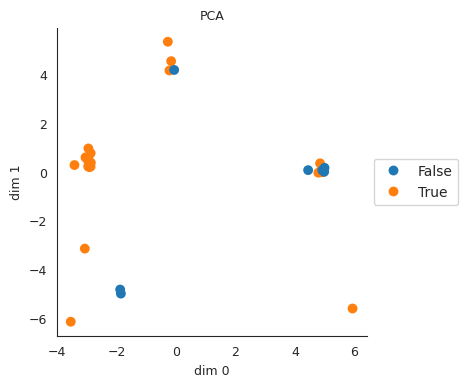

In [22]:
plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="seen_during_training", circle_size=50)

## Predicting with CellFlow

Predictions with {class}`~cellflow.model.CellFlow` require an {class}`adata <anndata.AnnData>` object with control cells. Moreover, we need `covariate_data` to store the information about what we would like to predict. 

In [23]:
adata_ctrl_for_prediction = adata_test[adata_test.obs["is_control"].to_numpy()]
covariate_data = adata_test[~adata_test.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])
covariate_data

,sample,Size_Factor,n.umi,RT_well,Drug1,Drug2,Well,n_genes,n_genes_by_counts,total_counts,...,control,cell_type,is_control,Drug1_pubchem_name,Drug1_pubchem_ID,Drug1_smiles,Drug2_pubchem_name,Drug2_pubchem_ID,Drug2_smiles,mode
Cell,,,,,,,,,,,,,,,,,,,,,
A01_A02_RT_BC_22_Lig_BC_17,sciPlex_theis,0.899999,2416,RT_22,control,Dacinostat,B10,1572,1569,2412.0,...,0,A549,False,control,<NA>,NaN,Dacinostat,6445533,C1=CC=C2C(=C1)C(=CN2)CCN(CCO)CC3=CC=C(C=C3)C=C...,test
A01_A02_RT_BC_28_Lig_BC_12,sciPlex_theis,1.136175,3050,RT_28,Panobinostat,Sorafenib,C4,2015,2015,3050.0,...,0,A549,False,Panobinostat,6918837,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO,Sorafenib,216239,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,test
A01_A02_RT_BC_4_Lig_BC_15,sciPlex_theis,0.932036,2502,RT_4,Panobinostat,SRT1720,A4,1649,1649,2502.0,...,0,A549,False,Panobinostat,6918837,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO,1001645-58-4,25232708,C1CN(CCN1)CC2=CSC3=NC(=CN23)C4=CC=CC=C4NC(=O)C...,test
A01_A02_RT_BC_52_Lig_BC_32,sciPlex_theis,2.259311,6065,RT_52,Panobinostat,Crizotinib,E4,3262,3260,6063.0,...,0,A549,False,Panobinostat,6918837,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO,Crizotinib,11626560,CC(C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=CN(N...,test
A01_A02_RT_BC_70_Lig_BC_12,sciPlex_theis,1.894990,5087,RT_70,control,Alvespimycin,F10,2801,2800,5086.0,...,0,A549,False,control,<NA>,NaN,alvespimycin,5288674,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,test
A01_A02_RT_BC_73_Lig_BC_11,sciPlex_theis,0.539404,1448,RT_73,Panobinostat,Curcumin,G1,1114,1113,1447.0,...,0,A549,False,Panobinostat,6918837,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO,curcumin,969516,COC1=C(C=CC(=C1)C=CC(=O)CC(=O)C=CC2=CC(=C(C=C2...,test
A01_A02_RT_BC_79_Lig_BC_57,sciPlex_theis,0.772226,2073,RT_79,SRT2104,Alvespimycin,G7,1459,1456,2070.0,...,0,A549,False,1093403-33-8,25108829,CC1=C(SC(=N1)C2=CN=CC=C2)C(=O)NC3=CC=CC=C3C4=C...,alvespimycin,5288674,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,test


We specify `sample_rep` to be `"X_pca"`, and provide a `condition_id_key` which defines the keys of the returned dictionary containing the predictions.

In [24]:
preds = cf.predict(adata=adata_ctrl_for_prediction, sample_rep="X_aligned", condition_id_key="condition", covariate_data=covariate_data)

100%|██████████| 7/7 [00:00<00:00, 1006.76it/s]


We now build an {class}`adata <anndata.AnnData>` object to store the predictions in {attr}`adata.obsm <anndata.AnnData.obsm>`:

In [25]:
adata_preds = []
for cond, array in preds.items():
    
    obs_data = pd.DataFrame({
        'condition': [cond] * array.shape[0]
    })
    adata_pred = ad.AnnData(X=np.empty((len(array),adata_train.n_vars)), obs=obs_data)
    adata_pred.obsm["X_pca"] = np.squeeze(array)
    adata_preds.append(adata_pred)

adata_preds = ad.concat(adata_preds)
adata_preds.var_names = adata_train.var_names

We now reconstruct the generated cells to gene space, which adds {attr}`uns['X_recon'] <anndata.AnnData.layers>` added.

In [26]:
reconstruct_pca(adata_preds, use_rep="X_pca", ref_adata=adata_train)
adata_preds.X = adata_preds.layers["X_recon"]

We also compute the metrics of CellFlow with respect to the ground truth data going through the encoder-decoder in order to separate CellFlow's model performance from the encoder-decoder. Note that this is what is computed during training with {class}`~cellflow.training.PCADecodedMetrics`. 

In [27]:
adata_test_recon = adata_test.copy()
cfpp.project_pca(adata_test_recon, ref_adata=adata_train)
cfpp.reconstruct_pca(query_adata=adata_test_recon, ref_adata=adata_train, layers_key_added="X_recon")
adata_test_recon.X = adata_test_recon.layers["X_recon"]

We now generate a latent space based on the whole data for evaluation of distributional metrics.

In [28]:
cfpp.centered_pca(adata, n_comps=30, method="rapids")
cfpp.project_pca(query_adata=adata_test, ref_adata=adata)
cfpp.project_pca(query_adata=adata_preds, ref_adata=adata)
cfpp.project_pca(query_adata=adata_test_recon, ref_adata=adata)

In [29]:
test_data_target_encoded = {}
test_data_target_decoded = {}
test_data_target_encoded_reconstructed = {}
test_data_target_decoded_reconstructed = {}
test_data_target_encoded_predicted = {}
test_data_target_decoded_predicted = {}

for cond in adata_preds.obs["condition"].unique():
    test_data_target_encoded[cond] = adata_test[adata_test.obs["condition"] == cond].obsm["X_pca"]
    test_data_target_decoded[cond] = adata_test[adata_test.obs["condition"] == cond].X.toarray()
    test_data_target_encoded_reconstructed[cond] = adata_test_recon[adata_test_recon.obs["condition"] == cond].obsm["X_pca"]
    test_data_target_decoded_reconstructed[cond] = adata_test_recon[adata_test_recon.obs["condition"] == cond].X.toarray()
    test_data_target_encoded_predicted[cond] = adata_preds[adata_preds.obs["condition"] == cond].obsm["X_pca"]
    test_data_target_decoded_predicted[cond] = adata_preds[adata_preds.obs["condition"] == cond].X

In [30]:
e_distances_true_pred = jax.tree_util.tree_map(
    compute_e_distance, test_data_target_encoded, test_data_target_encoded_predicted
)

r_squared_true_pred = jax.tree_util.tree_map(
    compute_r_squared, test_data_target_decoded, test_data_target_decoded_predicted
)

df_e_distance_true_pred = pd.DataFrame.from_dict(e_distances_true_pred, orient="index", columns=["energy_distance"])
df_r_squared_true_pred = pd.DataFrame.from_dict(r_squared_true_pred, orient="index", columns=["r_squared"])
df_metrics_true_pred = pd.merge(df_e_distance_true_pred, df_r_squared_true_pred, left_index=True, right_index=True)
df_metrics_true_pred["condition"] = df_metrics_true_pred.index

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.barplot(
    data=df_metrics_true_pred,
    x="condition",
    y="energy_distance",
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Energy Distance in latent space", fontsize=14)
axes[0].set_xlabel("Drug treatment", fontsize=12)
axes[0].set_ylabel("Energy Distance", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(
    data=df_metrics_true_pred,
    x="condition",
    y="r_squared",
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("R squared in Gene Expression Space", fontsize=14)
axes[1].set_xlabel("Drug treatment", fontsize=12)
axes[1].set_ylabel("R squared", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

sns.despine()
plt.tight_layout()
plt.show()

In [31]:
e_distances_recon_pred = jax.tree_util.tree_map(
    compute_e_distance, test_data_target_encoded_reconstructed, test_data_target_encoded_predicted
)

r_squared_recon_pred = jax.tree_util.tree_map(
    compute_r_squared, test_data_target_decoded_reconstructed, test_data_target_decoded_predicted
)

df_e_distance_recon_pred = pd.DataFrame.from_dict(e_distances_recon_pred, orient="index", columns=["energy_distance"])
df_r_squared_recon_pred = pd.DataFrame.from_dict(r_squared_recon_pred, orient="index", columns=["r_squared"])
df_metrics_recon_pred = pd.merge(df_e_distance_recon_pred, df_r_squared_recon_pred, left_index=True, right_index=True)
df_metrics_recon_pred["condition"] = df_metrics_recon_pred.index

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.barplot(
    data=df_metrics_recon_pred,
    x="condition",
    y="energy_distance",
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Energy Distance in latent space", fontsize=14)
axes[0].set_xlabel("Drug treatment", fontsize=12)
axes[0].set_ylabel("Energy Distance", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(
    data=df_metrics_recon_pred,
    x="condition",
    y="r_squared",
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("R squared in Gene Expression Space", fontsize=14)
axes[1].set_xlabel("Drug treatment", fontsize=12)
axes[1].set_ylabel("R squared", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

sns.despine()
plt.tight_layout()
plt.show()

From the comparison of the plots we can conclude the following:
- CellFlow has almost perfectly learnt the mean gene expression profile, as the R squared is almost above 0.98 for all test conditions *with respect to the data undergoing encoding and decoding*
- However, with respect to the ground truth data (what is reported throughout the manuscript), the R squared is on average aroud 0.9. Thus, the encoder-decoder architecture has to be improved. 
- The energy distance is less sensitive to the effect of the encoder-decoder, as it filters out the noise. Hence, the distances between CellFlow's predictions and the ground truth are more similar to the distances between CellFlow's predictions and the ground truth going through the encoder-decoder.

All in all, we should use a more powerful encoder-decoder here. One way to do this is increasing the number of principal components.

In [32]:
df_metrics_recon_pred

,energy_distance,r_squared,condition
Panobinostat+Crizotinib,6.929597,0.992093,Panobinostat+Crizotinib
Panobinostat+Curcumin,1.341948,0.998179,Panobinostat+Curcumin
Panobinostat+SRT1720,2.101867,0.997297,Panobinostat+SRT1720
Panobinostat+Sorafenib,1.533446,0.998002,Panobinostat+Sorafenib
SRT2104+Alvespimycin,12.955380,0.983267,SRT2104+Alvespimycin
control+Alvespimycin,11.986608,0.984421,control+Alvespimycin
control+Dacinostat,5.757614,0.992954,control+Dacinostat


In [33]:
df_metrics_true_pred

,energy_distance,r_squared,condition
Panobinostat+Crizotinib,7.113812,0.871772,Panobinostat+Crizotinib
Panobinostat+Curcumin,1.363731,0.900114,Panobinostat+Curcumin
Panobinostat+SRT1720,2.104576,0.925166,Panobinostat+SRT1720
Panobinostat+Sorafenib,1.554319,0.893161,Panobinostat+Sorafenib
SRT2104+Alvespimycin,14.041352,0.899901,SRT2104+Alvespimycin
control+Alvespimycin,13.771369,0.884888,control+Alvespimycin
control+Dacinostat,5.836791,0.957439,control+Dacinostat
